# The symmetric matter EOS from $\chi$EFT 

### Authors: Alexandra Semposki

### Date last edited: 29 March 2024

#### [Adapted from: derivatives-bands.ipynb notebook in the BUQEYE nuclear-matter-convergence repository](https://github.com/buqeye/nuclear-matter-convergence/blob/master/analysis/derivatives-bands.ipynb)

This notebook reproduces the results from the paper _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by BUQEYE members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)), with order-by-order predictions of the pressure and speed of sound of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions.

This notebook uses modules from standard Python packages, third-party packages corner, gsum, and gptools, and the nuclear_matter package from BUQEYE, found [here](https://github.com/buqeye/nuclear-matter-convergence). The code from that repository was modified in the source file `derivatives_new.py`, where the extrapolation of the EOS from $\chi$EFT to $100n_{0}$ using the Prakash, Ainsworth, Lattimer (PAL) EOS was implemented. This is used for the pointwise Bayesian model mixing section of the present paper (Sec. III). 

---

This notebook also generates results for $E(n)/N$ (PNM) and the symmetry energy $E_{sym}$ from $\chi$EFT, and hence produces the necessary quantities used to obtain the EOS for neutron star matter (NSM).

---

### Table of contents

1. [Setting up the calculation](#setup)
2. [Calculation of $P(n)$](#calc_p)
3. [Obtaining $\varepsilon(n)$](#calc_eps)
4. [Computing the sound speed squared, $c_{s}^{2}(n)$](#cs2) 

---

## Setting up the calculation  <a id="setup"></a>

First, we need to import all of the required packages. The paths are set up such that the top directory is the GitHub repository that this notebook is contained in (EOS_BMM_SNM). If you have installed `gsum`, `gptools`, and `nuclear-matter-convergence` within the top directory, all of the paths here will work properly. 

Let's import all of our requirements below.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Standard Python modules
import numpy as np
from scipy import stats
from scipy import interpolate
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
from os.path import join
import matplotlib.patches as mpatches
import pandas as pd
import time

# import source code
import sys
sys.path.append('../src')

from chiral import Chiral

import corner  # https://corner.readthedocs.io/en/latest/

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools (development version)
# and install with 'pip install .' from inside repo. 
import gptools   # https://gptools.readthedocs.io/en/latest/

# accessing the cloned repo of nuclear-matter-convergence
sys.path.append('../nuclear-matter-convergence/')

# importing all necessary functions
from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation
from nuclear_matter import lighten_color

### Set up the defaults for figures

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. We also provide here all of the plotting functions used in this notebook that are not contained in the `nuclear_matter` scripts. 

In [2]:
setup_rc_params()

In [3]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

# sets the colors and styling of the curves and bands in the plots
def curve_plus_bands_plot(ax, x, y, std, color_68=None, color_95=None, 
                          zorder=None, edgecolor=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
    ax.plot(x, y, zorder=zorder, **kwargs)
    if color_95 is not None:
        ax.fill_between(x, y + 2*std, y - 2*std, facecolor=color_95, 
                        edgecolor=edgecolor, zorder=zorder)
    if color_68 is not None:
        ax.fill_between(x, y + std, y - std, facecolor=color_68,
                        edgecolor=edgecolor, zorder=zorder, alpha=0.7)
    return ax

In [4]:
# adds either a rectangle or a vertical line 
# for where saturation density is located
def highlight_nsat(ax, nsat=0.164, zorder=0, band=False):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)
    if band:
        import matplotlib.transforms as transforms
        trans = transforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        n0_std = 0.007
        rect = mpatches.Rectangle(
            (nsat-n0_std, 0), width=2*n0_std, height=1,
            transform=trans, facecolor='0.85', edgecolor='0.6',
            linewidth=0.6,
            alpha=0.7, zorder=zorder-0.01
        )
        ax.add_patch(rect)

density_label = r'Density $n$ [fm$^{-3}$]'
kf_label = r'Fermi momentum $k_{F}$ [fm$^{-1}$]'

# plotter to plot with or without truncation error 
# from the truncation error calculations
def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, \
    axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

# handles plotting the order-by-order results for each physical
# quantity (E/A, P, cs2, etc.)
def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, nsat_n0=False, ax=None, c='k',
    color_68=None, color_95=None, markersize=3, edgecolor=None, zorder=0, wrt_kf=False,
    **kwargs
):
    if wrt_kf is True:
        kf = fermi_momentum(density,4)
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3), dpi=600) 
    curve_plus_bands_plot(
        ax, density, y, std, c=c, color_68=color_68, color_95=color_95,
        edgecolor=edgecolor, zorder=zorder, **kwargs
    )
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
    if add_nsat is True and nsat_n0 is True:
        highlight_nsat(ax, nsat=1.0, zorder=zorder)
    elif add_nsat:
        highlight_nsat(ax, zorder=zorder)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax

# plotter to handle the panelling of each figure for order-by-order plotting
def plot_obs_panels(density, y, dy, orders, density_data=None, y_data=None, colors=None, \
                    axes=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(5, 5), dpi=600) 
    fig = plt.gcf()
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    
    if colors is None:
        color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
        cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
        colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
    
    light_colors = [lighten_color(color) for color in colors]
    dark_colors = [lighten_color(color, 1.5) for color in colors]

    for j, ax in enumerate(axes.ravel()):
        for i, n in enumerate(orders[:j+1]): 
            if y_data is not None:
                y_data_i = y_data[:, i]
            else:
                y_data_i = None

            plot_obs_vs_density(
                density,
                y[:, i],
                dy[:, i],
                ax=ax,
                c=colors[i],
                color_68=light_colors[i],
                edgecolor=colors[i], 
                add_nsat=i==j, 
                zorder=i/3,
                density_data=density_data,
                y_data=y_data_i,
                markersize=3,
                **kwargs
            )
        ax.axhline(0, 0, 1, c='k', lw=0.8)
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both') # stop for loop after line
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    axes[0,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    return fig, axes

## Standard Case

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}



In [5]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

# Nuclear Matter Application <a id="nuclear_matter"></a>

Our specific use case: we fit a GP to data, in this case from a physics simulation, and incorporate theory error from custom kernel design (see `derivatives.py` for the original source code from the BUQEYE group).

## Import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions with `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [10]:
# choose density range and initialize the class to run the source code
density_input = np.linspace(0.05, 0.34, 600) 
#density_input = np.linspace(0.05,16.4,600) # uncomment to run the extended version for pointwise mixing
chiral = Chiral(density_input=density_input, Lambda = 500, high_density=True)

# set the density from the class
density_all = chiral.density_all
len(density_all) # should show number of chosen points

600

In [11]:
# class variables checker (should read 600 MeV if all is well)
chiral.breakdown

600

Visualize the EOS. The data below comes from fourth-order MBPT calculations (see [arXiv:2004.07805](https://arxiv.org/abs/2004.07805), [arXiv:1710.08220](https://arxiv.org/abs/1710.08220) for details).

In [12]:
# some definitions for plotting
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# set plot order labels
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']

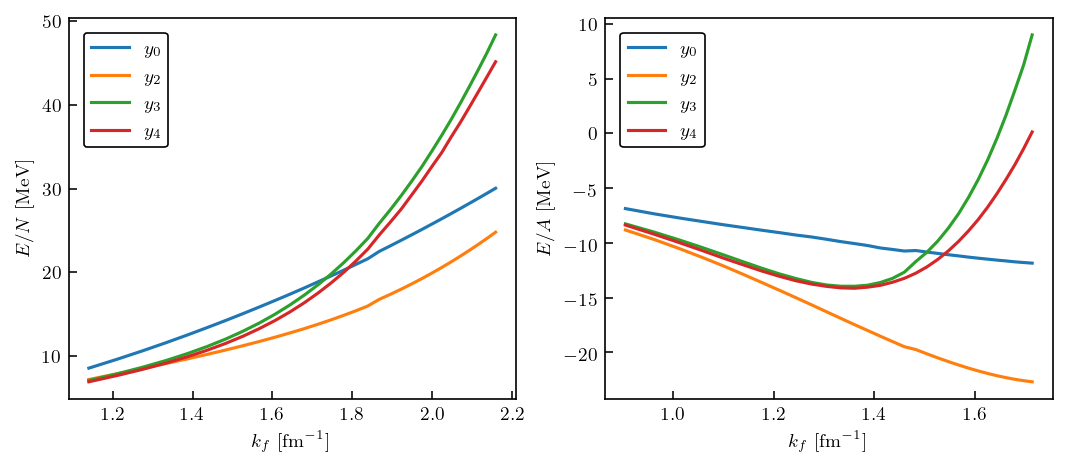

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(chiral.orders):
    ax[0].plot(chiral.kf_n, chiral.y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(chiral.orders):
    ax[1].plot(chiral.kf_s, chiral.y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [14]:
# call the containers for PNM, SNM, and symmetry energy 
# from the modified source code
from derivatives_new import ObservableContainer, SymmetryEnergyContainer

# set to True to see the results as they are output
verbose = True

# set up the containers and run the interpolation
# if running farther than 0.34 fm^-3, select extend=True to use PAL EOS
obs_neutron, obs_nuclear, obs_sym_energy = \
chiral.data_interpolation(density_int=None, kf_s_int=None, extend=False)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 7
Setup time: 84.97492408752441


The values of $\nu$ above correspond to the highest order to which one should fit, based on the interpolation, a functional

\begin{align}
    \sum_{\nu = 2}^M c_\nu \left(\frac{n}{n_0}\right)^{\nu/3},
\end{align}

which can be used to attempt to interpolate the MBPT results for energy per particle. However, because finite differences used here fail, especially when one considers the second derivative, we use instead our GPs to construct the means and truncation errors of the data.

Now we will continue on and look at the truncation error calculation we get when using `gsum` and `gptools` to perform uncertainty quantification on the energy per particle for SNM.

In [15]:
# convert array from density to kf
d = density_all
kf = (3.0 * np.pi**2.0 * d/2.0)**(1.0/3.0)

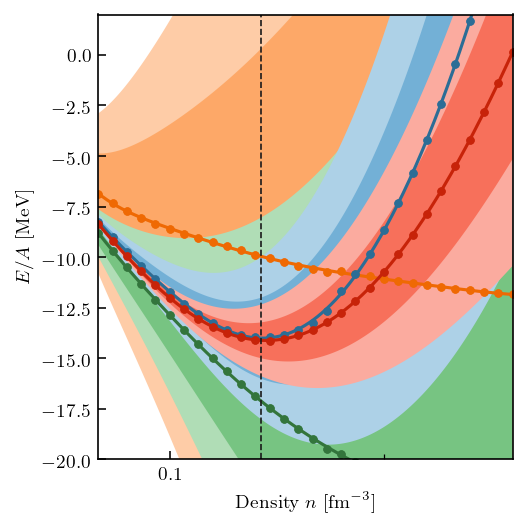

In [16]:
# plotting the E/A result with truncation errors now (get_pred, get_std functions below)
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True), 
        # just proof of finite difference failing, if deriv>=2
        wrt_kf=True,
    )
    
ax.set_xticks([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9])#, 2.2, 2.5, 2.8, 3.1])
ax.set_ylim(-20, 2.0)
ax.set_xlim(0.05,.34)
ax.set_ylabel(r'$E/A$ [MeV]');

# calculate Q wrt kf instead of n 
hbarc = 197.327 
kf_cutoff = 600/hbarc

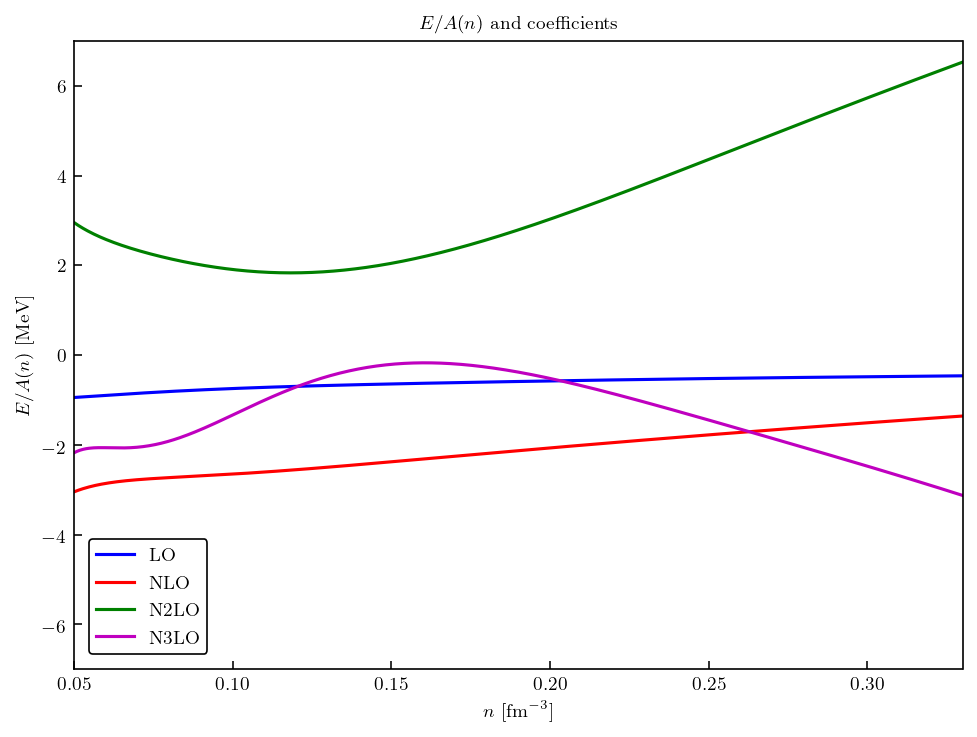

In [17]:
# plotting the coefficients of the series expansion for SNM
# this is using the y(x) formalism of gsum
epp = [obs_nuclear.get_pred(order=n, deriv=0) for n in chiral.orders]

hbarc = 197.327 # MeV fm

# we want to see if the coefficients at each order are naturally sized
kf_s = hbarc * (3.0 * np.pi**2.0 * chiral.density_all/2.0)**(1.0/3.0)  #[MeV]
kf_0 = hbarc * (3.0 * np.pi**2.0 * 0.164/2.0)**(1.0/3.0)    # [MeV]
yref_n = 16.0 * (kf_s/kf_0)**(2.0)    # [MeV]

# try dividing by yref here (simple test for mean results)
LO_coeff = epp[0]/yref_n

# Q
exp_Q = (kf_s/chiral.breakdown)   # [dimensionless]

# second one (now mindful of Q)
NLO_coeff = ((epp[1]/yref_n) - LO_coeff)/(exp_Q)**2.0

# third one (N2LO)
N2LO_coeff = ((epp[2]/yref_n) - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**3.0

# fourth one (N3LO)
N3LO_coeff = ((epp[3]/yref_n) - N2LO_coeff*(exp_Q)**3.0 - NLO_coeff*(exp_Q)**2.0 - LO_coeff)/(exp_Q)**4.0

plt.xlim(0.05, 0.33)
plt.ylim(-7,7)
plt.xlabel(r'$n$ [fm$^{-3}$]')
plt.ylabel(r'$E/A(n)$ [MeV]')
plt.title(r'$E/A(n)$ and coefficients')
plt.plot(chiral.density_all, LO_coeff, 'b', label='LO')
plt.plot(chiral.density_all, NLO_coeff, 'r', label='NLO')
plt.plot(chiral.density_all, N2LO_coeff, 'g', label='N2LO')
plt.plot(chiral.density_all, N3LO_coeff, 'm', label='N3LO')
plt.legend(loc='lower left')
plt.show()

Now that we have a handle on the EFT itself, we will move to the truncation errors. For each order, they should be on the order of the next power. We've already plotted the E/A result with truncation error, but now let's look at if we only use truncation error, if we only use interpolation error from the GP, and if we combine them together (as is done in the final result for the truncation error bands).

Using only truncation error:


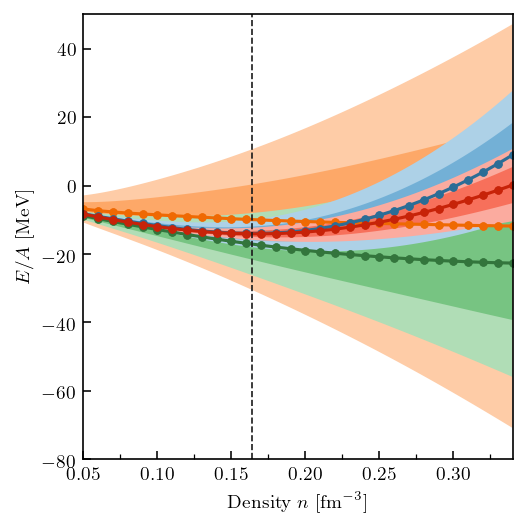

Using only interpolation error:


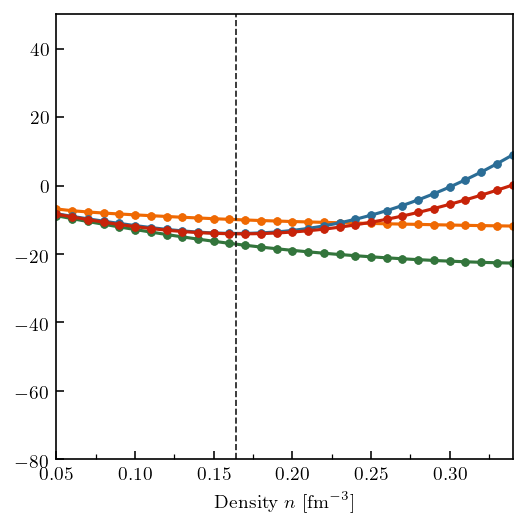

Using both truncation and interpolation error:


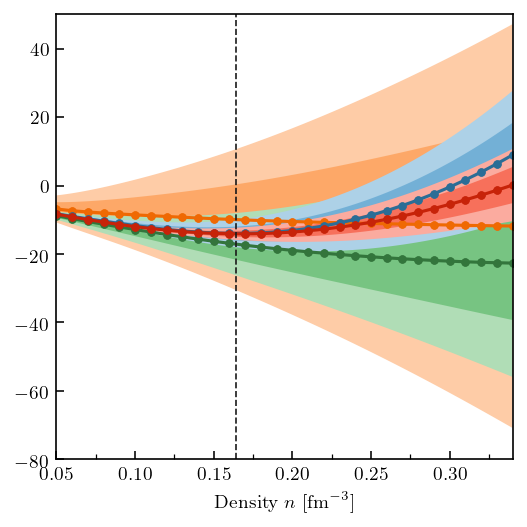

In [18]:
# look at the truncation error bands now at each order and test their scaling
trunc_std = np.zeros([len(chiral.density_all), len(chiral.orders)]).T
for i, n in enumerate(chiral.orders):
    trunc_std[i] = obs_nuclear.get_trunc_std(order=n, deriv=0)

# now take this and plot it 
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)

print('Using only truncation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_trunc_std(order=n, deriv=0),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
ax.set_ylabel(r'$E/A$ [MeV]');
plt.show()

# now only plot the interpolation GP errors
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)
print('Using only interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=False),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

# now plot both
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
ax.set_ylim(-80.0, 50.0)
print('Using both truncation and interpolation error:')
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(chiral.orders)-1,
        density_data=chiral.density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=0, wrt_kf=True),
    )
plt.show()

We see that, at this point in density, there is very little GP interpolation error---which makes sense, since we are within the range of our data. If we were to increase the density range out farther, we would see this quantity increase, since we will be outside of our data range and the GP will resort to extrapolation.

---

## Make Order-by-Order Predictions with Uncertainties <a id="order_by_order"></a>

Our GPs are defined to be stationary over momentum, but most formula for EOS properties use derivatives with respect to density.
So our derivatives must make use of the chain rule.
This is all handled inside functions like `compute_pressure`, `compute_pressure_cov`, etc., which can all be told whether the inputs use `kf` or `n` as the space for derivatives.

In [19]:
from nuclear_matter import kf_derivative_wrt_density

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


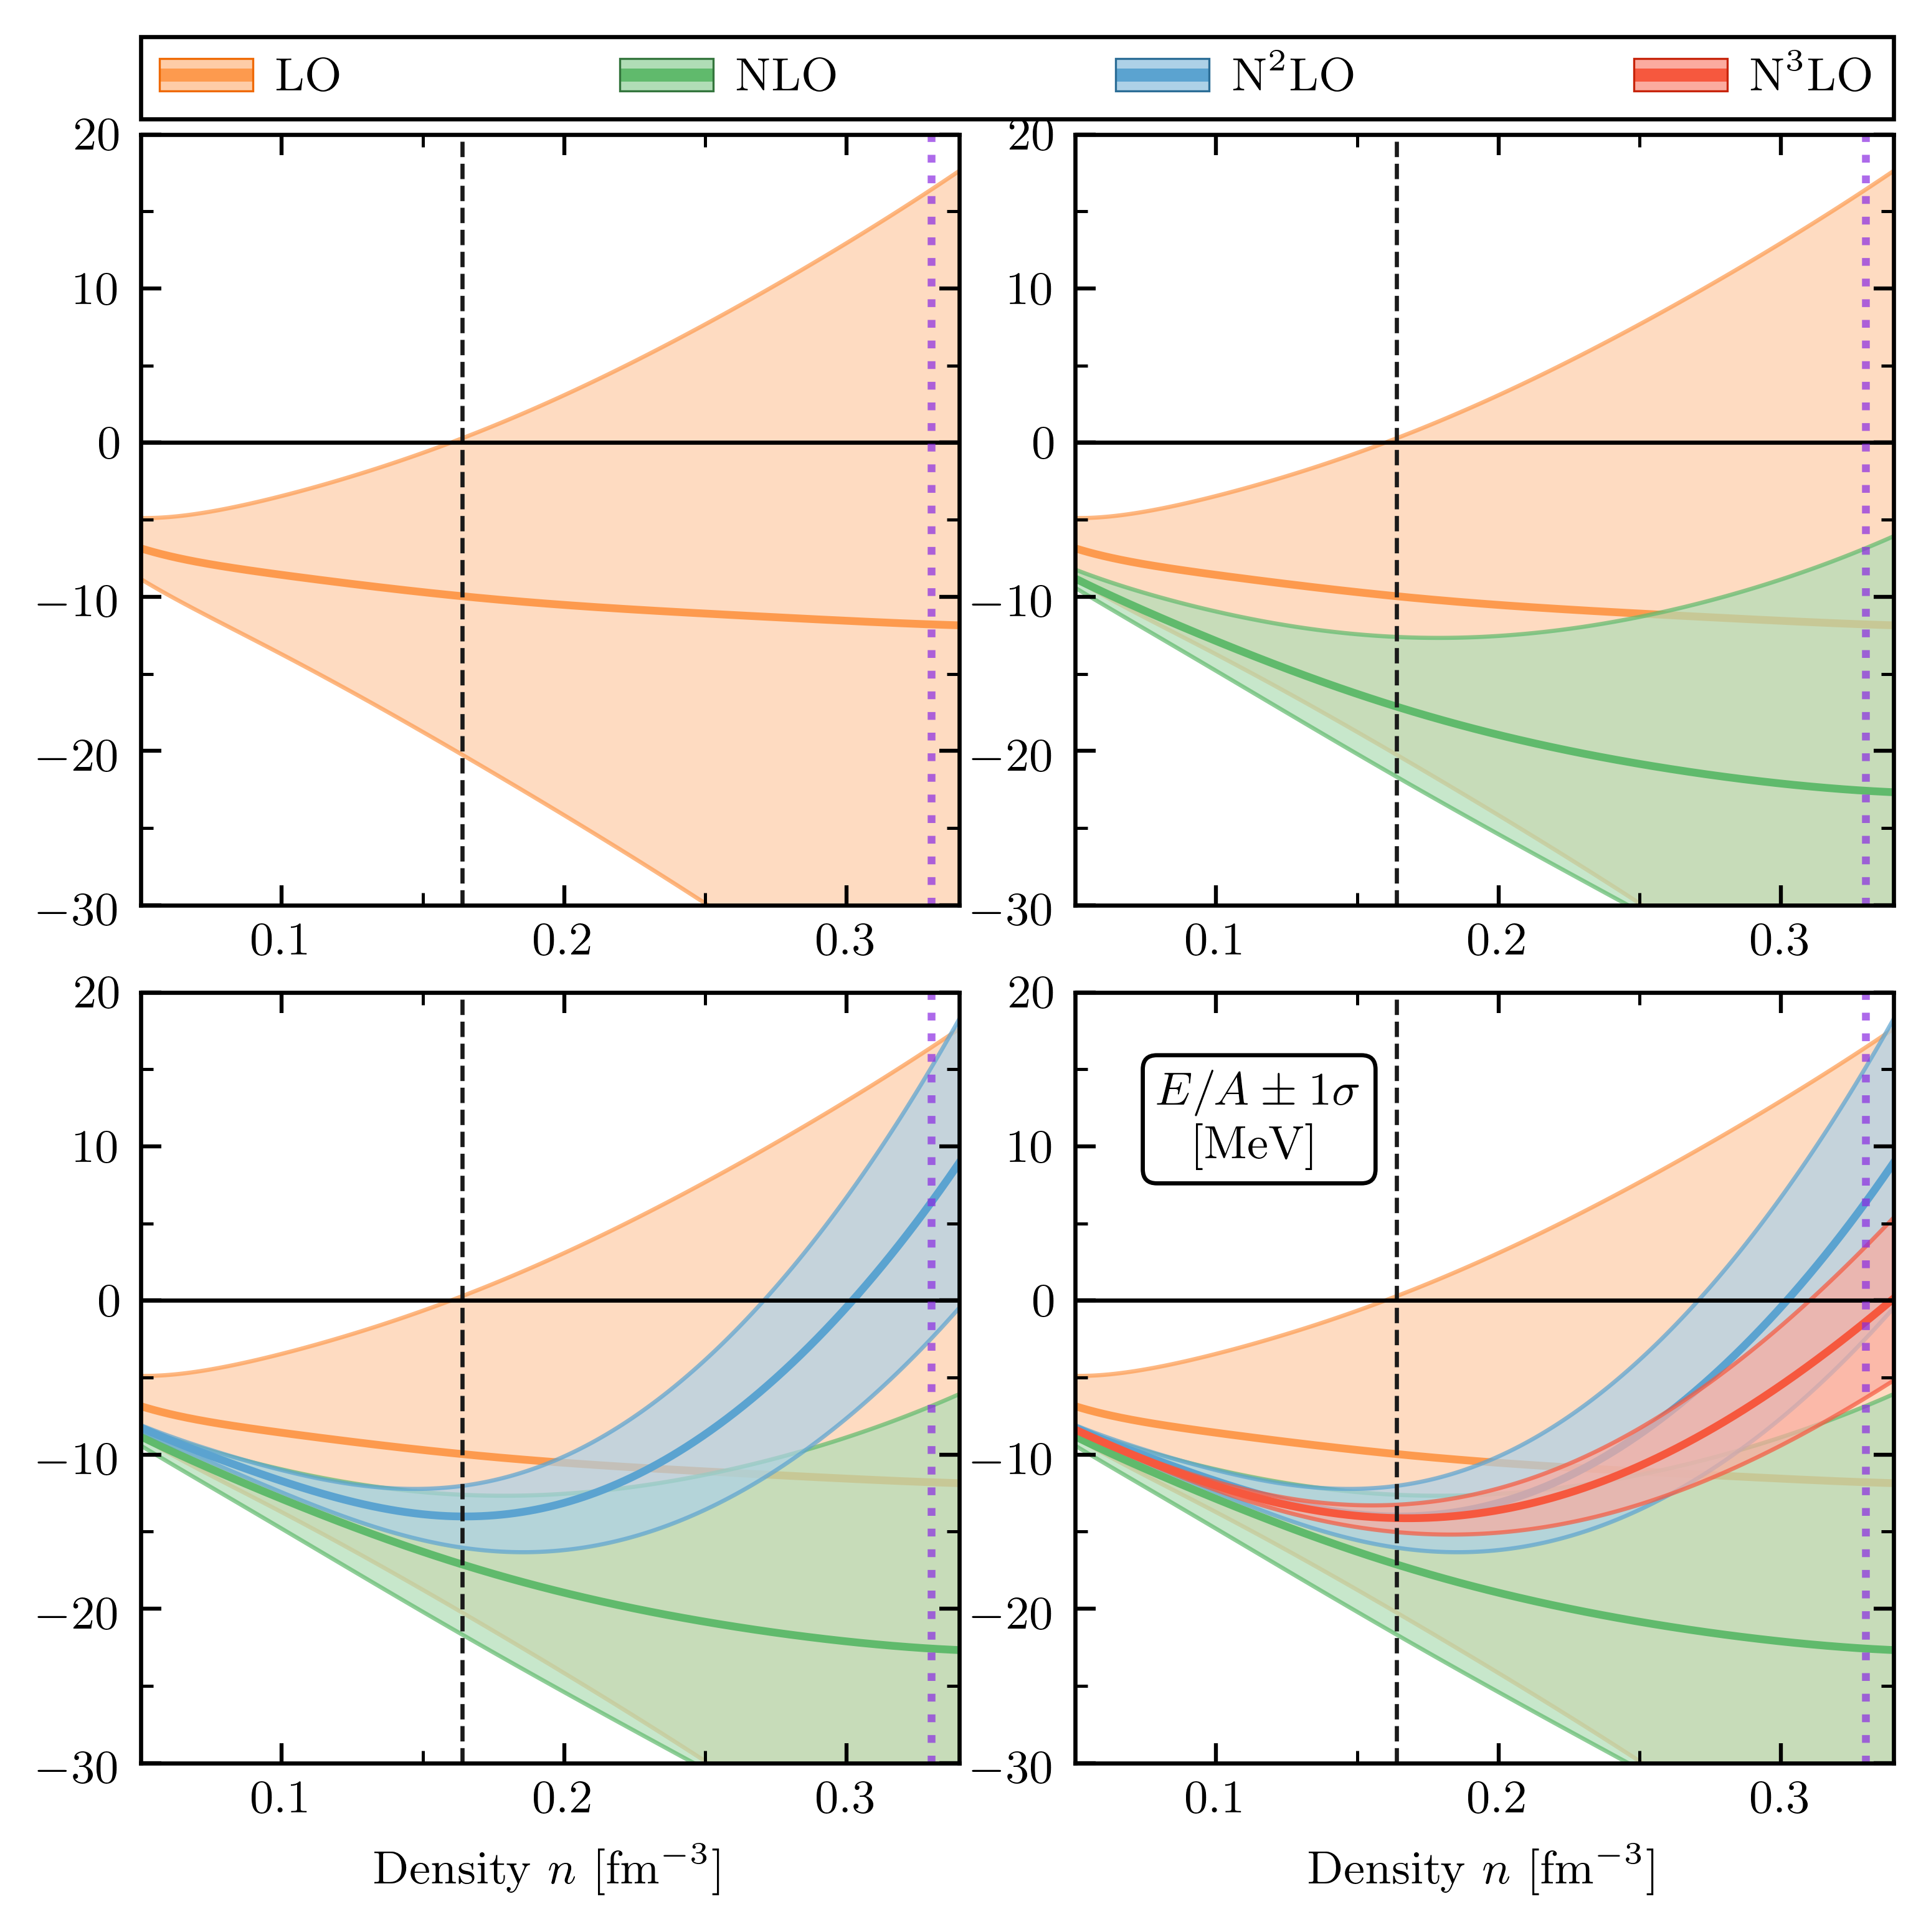

In [20]:
# plot first the energy per particle, not including the rest mass (can be added below)
energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=False)

fig, axes = plot_obs_panels(
    density_all, y=energies_s_mn, dy=energy_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-30, 20)
axes[1, 0].set_ylim(-30, 20)
axes[1, 1].set_ylim(-30, 20)
axes[0, 1].set_ylim(-30, 20)
for ax in axes.reshape(-1):
    ax.set_xlim(0.05, 0.34)
    ax.axvline(x=0.33, color='blueviolet', linestyle='dotted', alpha=0.7)

label = r"""$E/A \pm 1\sigma$
[MeV]""" 
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

### Creating a one-panel plot version

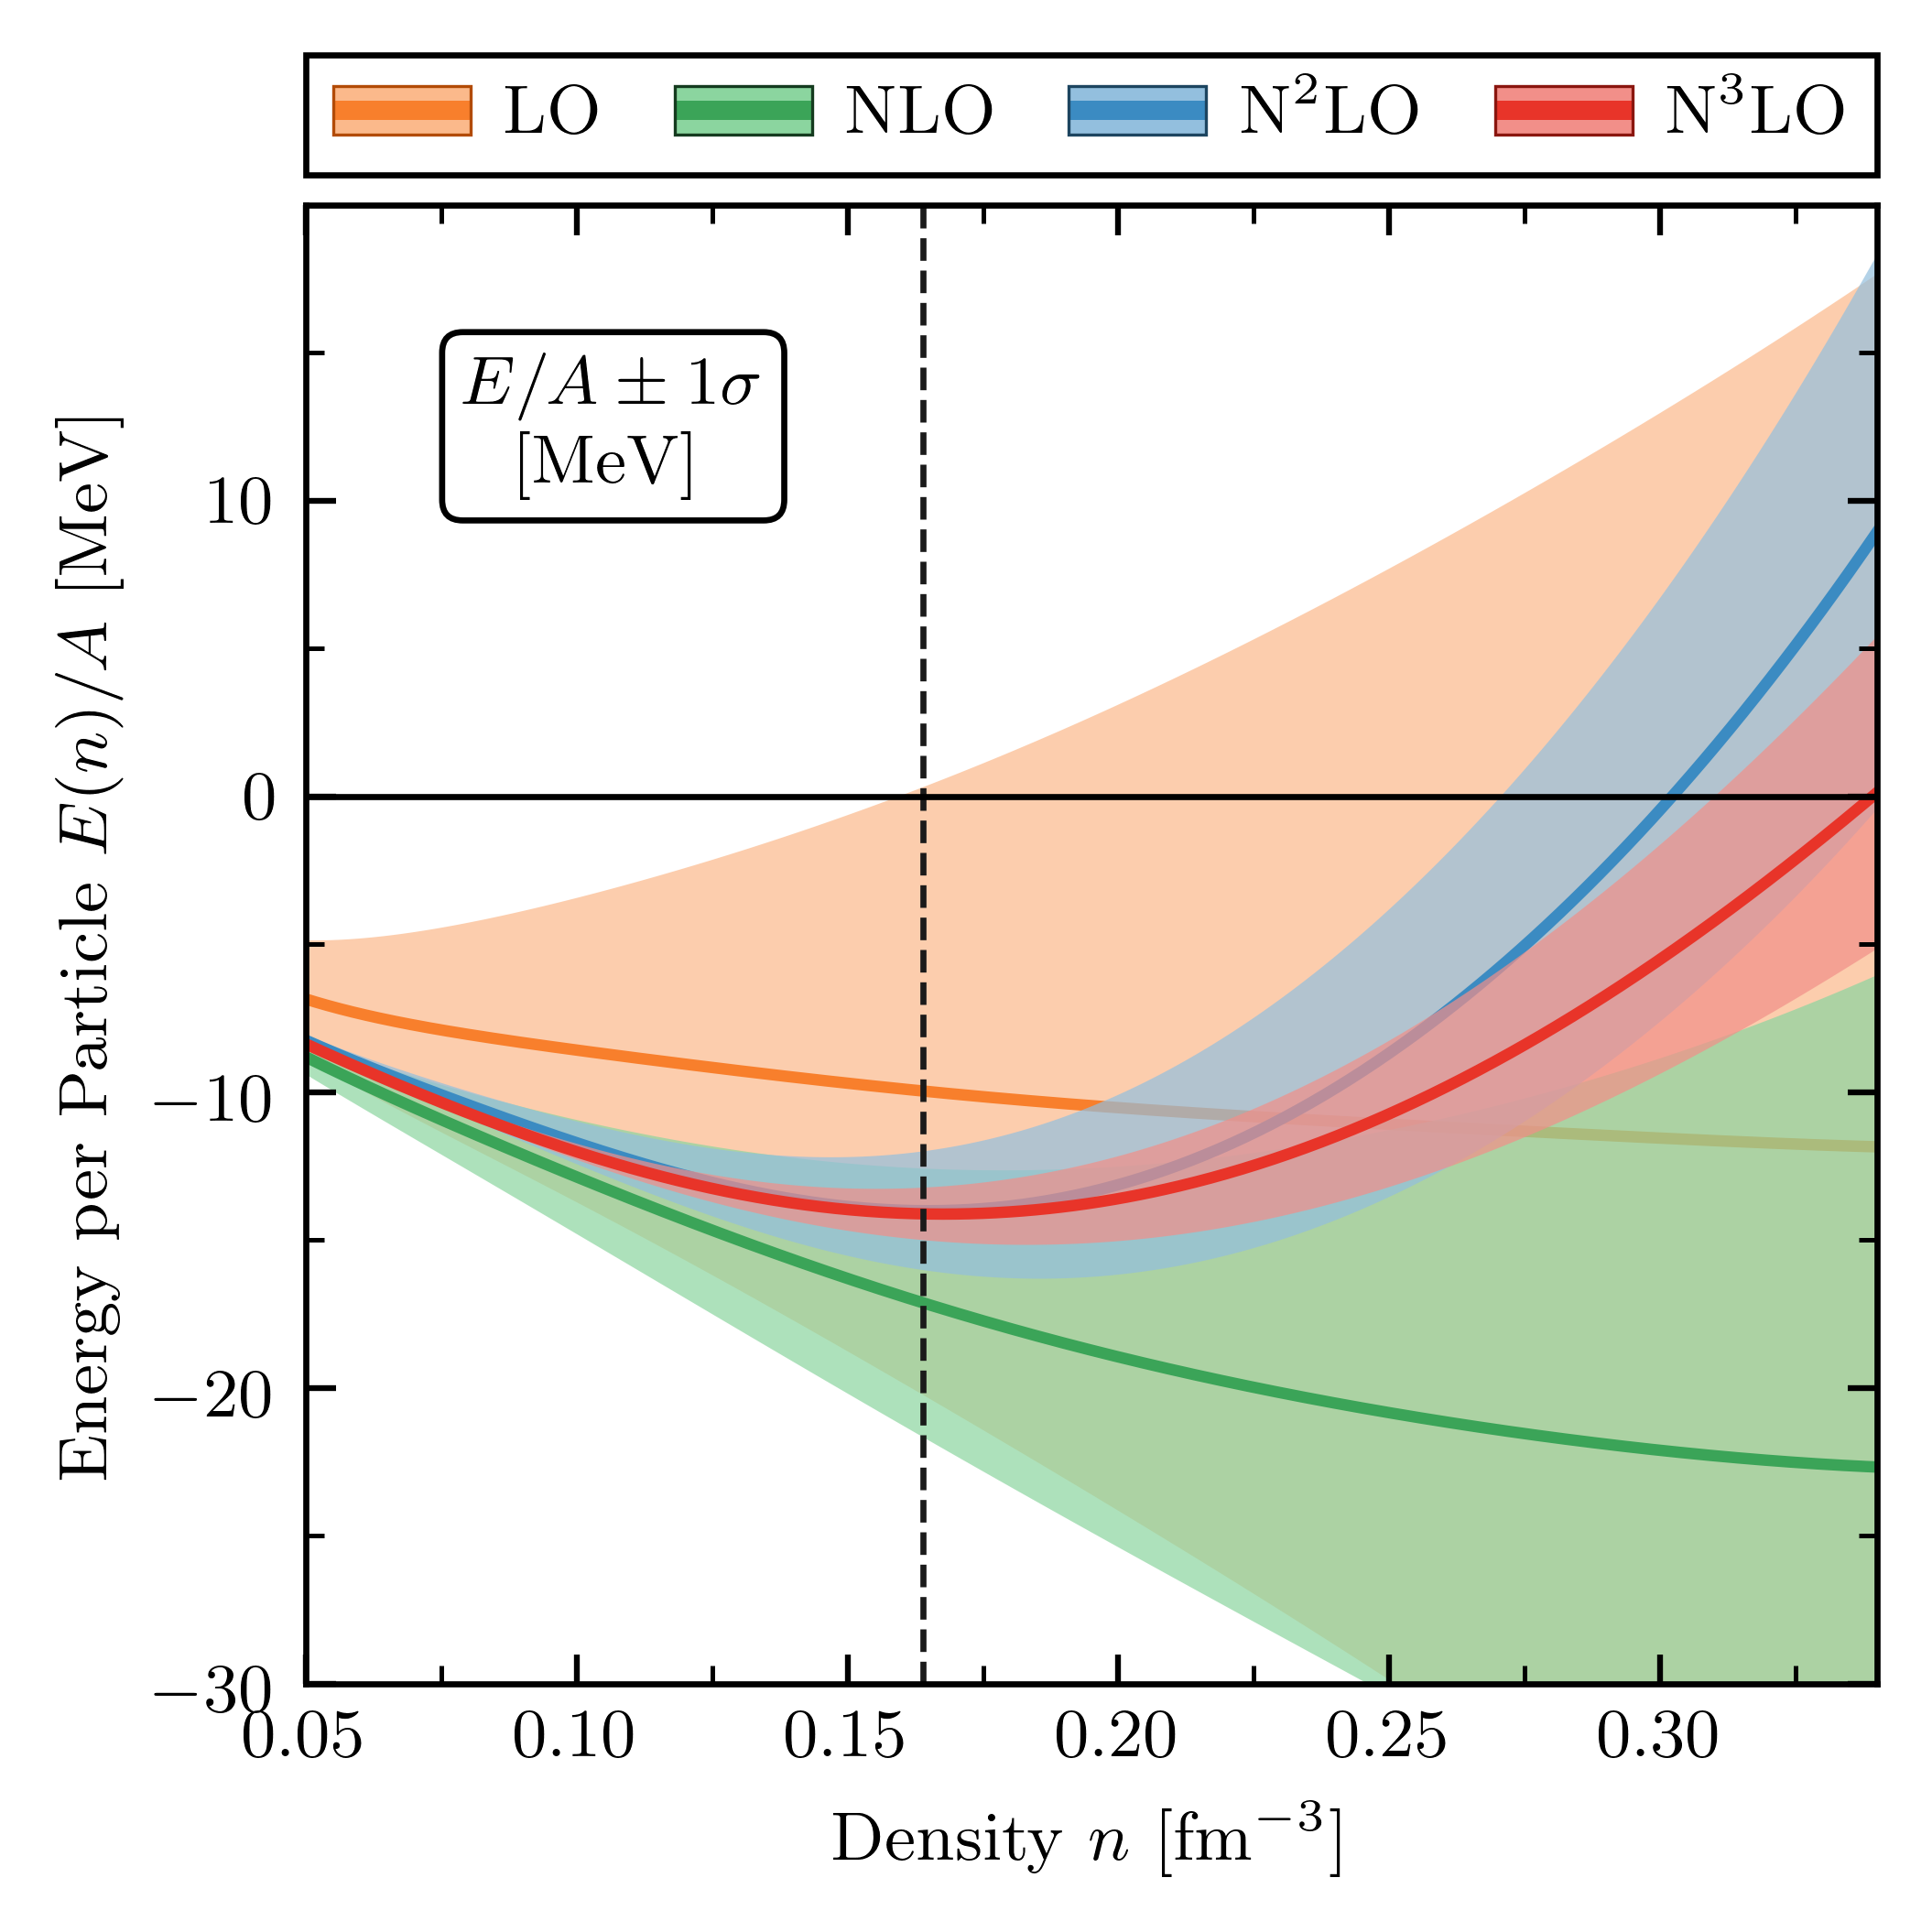

In [21]:
# plot first the energy per particle, not including the rest mass (can be added below)
energies_s_mn, energy_s_stds = chiral.energy_per_particle(add_rest_mass=False)

fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        energies_s_mn[:,i],
        energy_s_stds[:,i],
        ax=ax,
        color_68=light_colors[i],
   #     color_95=light_colors[i],
        c=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
    )
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both') # stop for loop after line
ax.axhline(0, 0, 1, c='k', lw=0.8);
ax.set_ylabel(r'$\textrm{Energy per Particle}~E(n)/A$ [MeV]');
ax.set_ylim(-30, 20-1e-5);
ax.set_xlim(0.05, 0.34)

label = r"""$E/A \pm 1\sigma$
[MeV]""" 
ax.text( 
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('one_panel_EA.PNG')
plt.show()

---

## Calculation of $P(n)$ <a id="calc_p"></a>

The pressure is given by
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

In [22]:
# set the value of saturation density
n0 = 0.164

# set the value of hbarc
hbarc = 197.327 # MeV fm

# also calculate the Fermi gas pressure now for scaling later
pressure_free = np.zeros([len(density_all), 4])
for i in range(4):
    pressure_free[:,i] = ((1.0/(2.0*np.square(np.pi)))*(chiral.kf_s_all**4.0))*(hbarc)

In [23]:
# calculate the values of Q at each point in density space
def q_calc(density):
    # momentum first from density_all
    hbarc = 197.327 # MeV fm 
    kf = ((3.0*np.pi**2.0)*density/2.0)**(1.0/3.0)  # fm^-1
    lamb = 600./hbarc   # MeV/MeV fm = fm^-1
    Q_vals = kf/lamb
    
    return Q_vals

# calculate the value of Q at 0.239 fm^-3
q_calc(0.65)

# calculate it only between the current 
# limits of density on the plot
# current_lims = [0.05/n0, 2.0/n0]
# q_vals = q_calc(density_all)

0.699525230490762

In [24]:
# call the chiral pressure function 
pressures_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')

# fill std with zeros for initial plot
pressure_s_stds_0 = np.zeros([len(density_all), len(chiral.orders)])

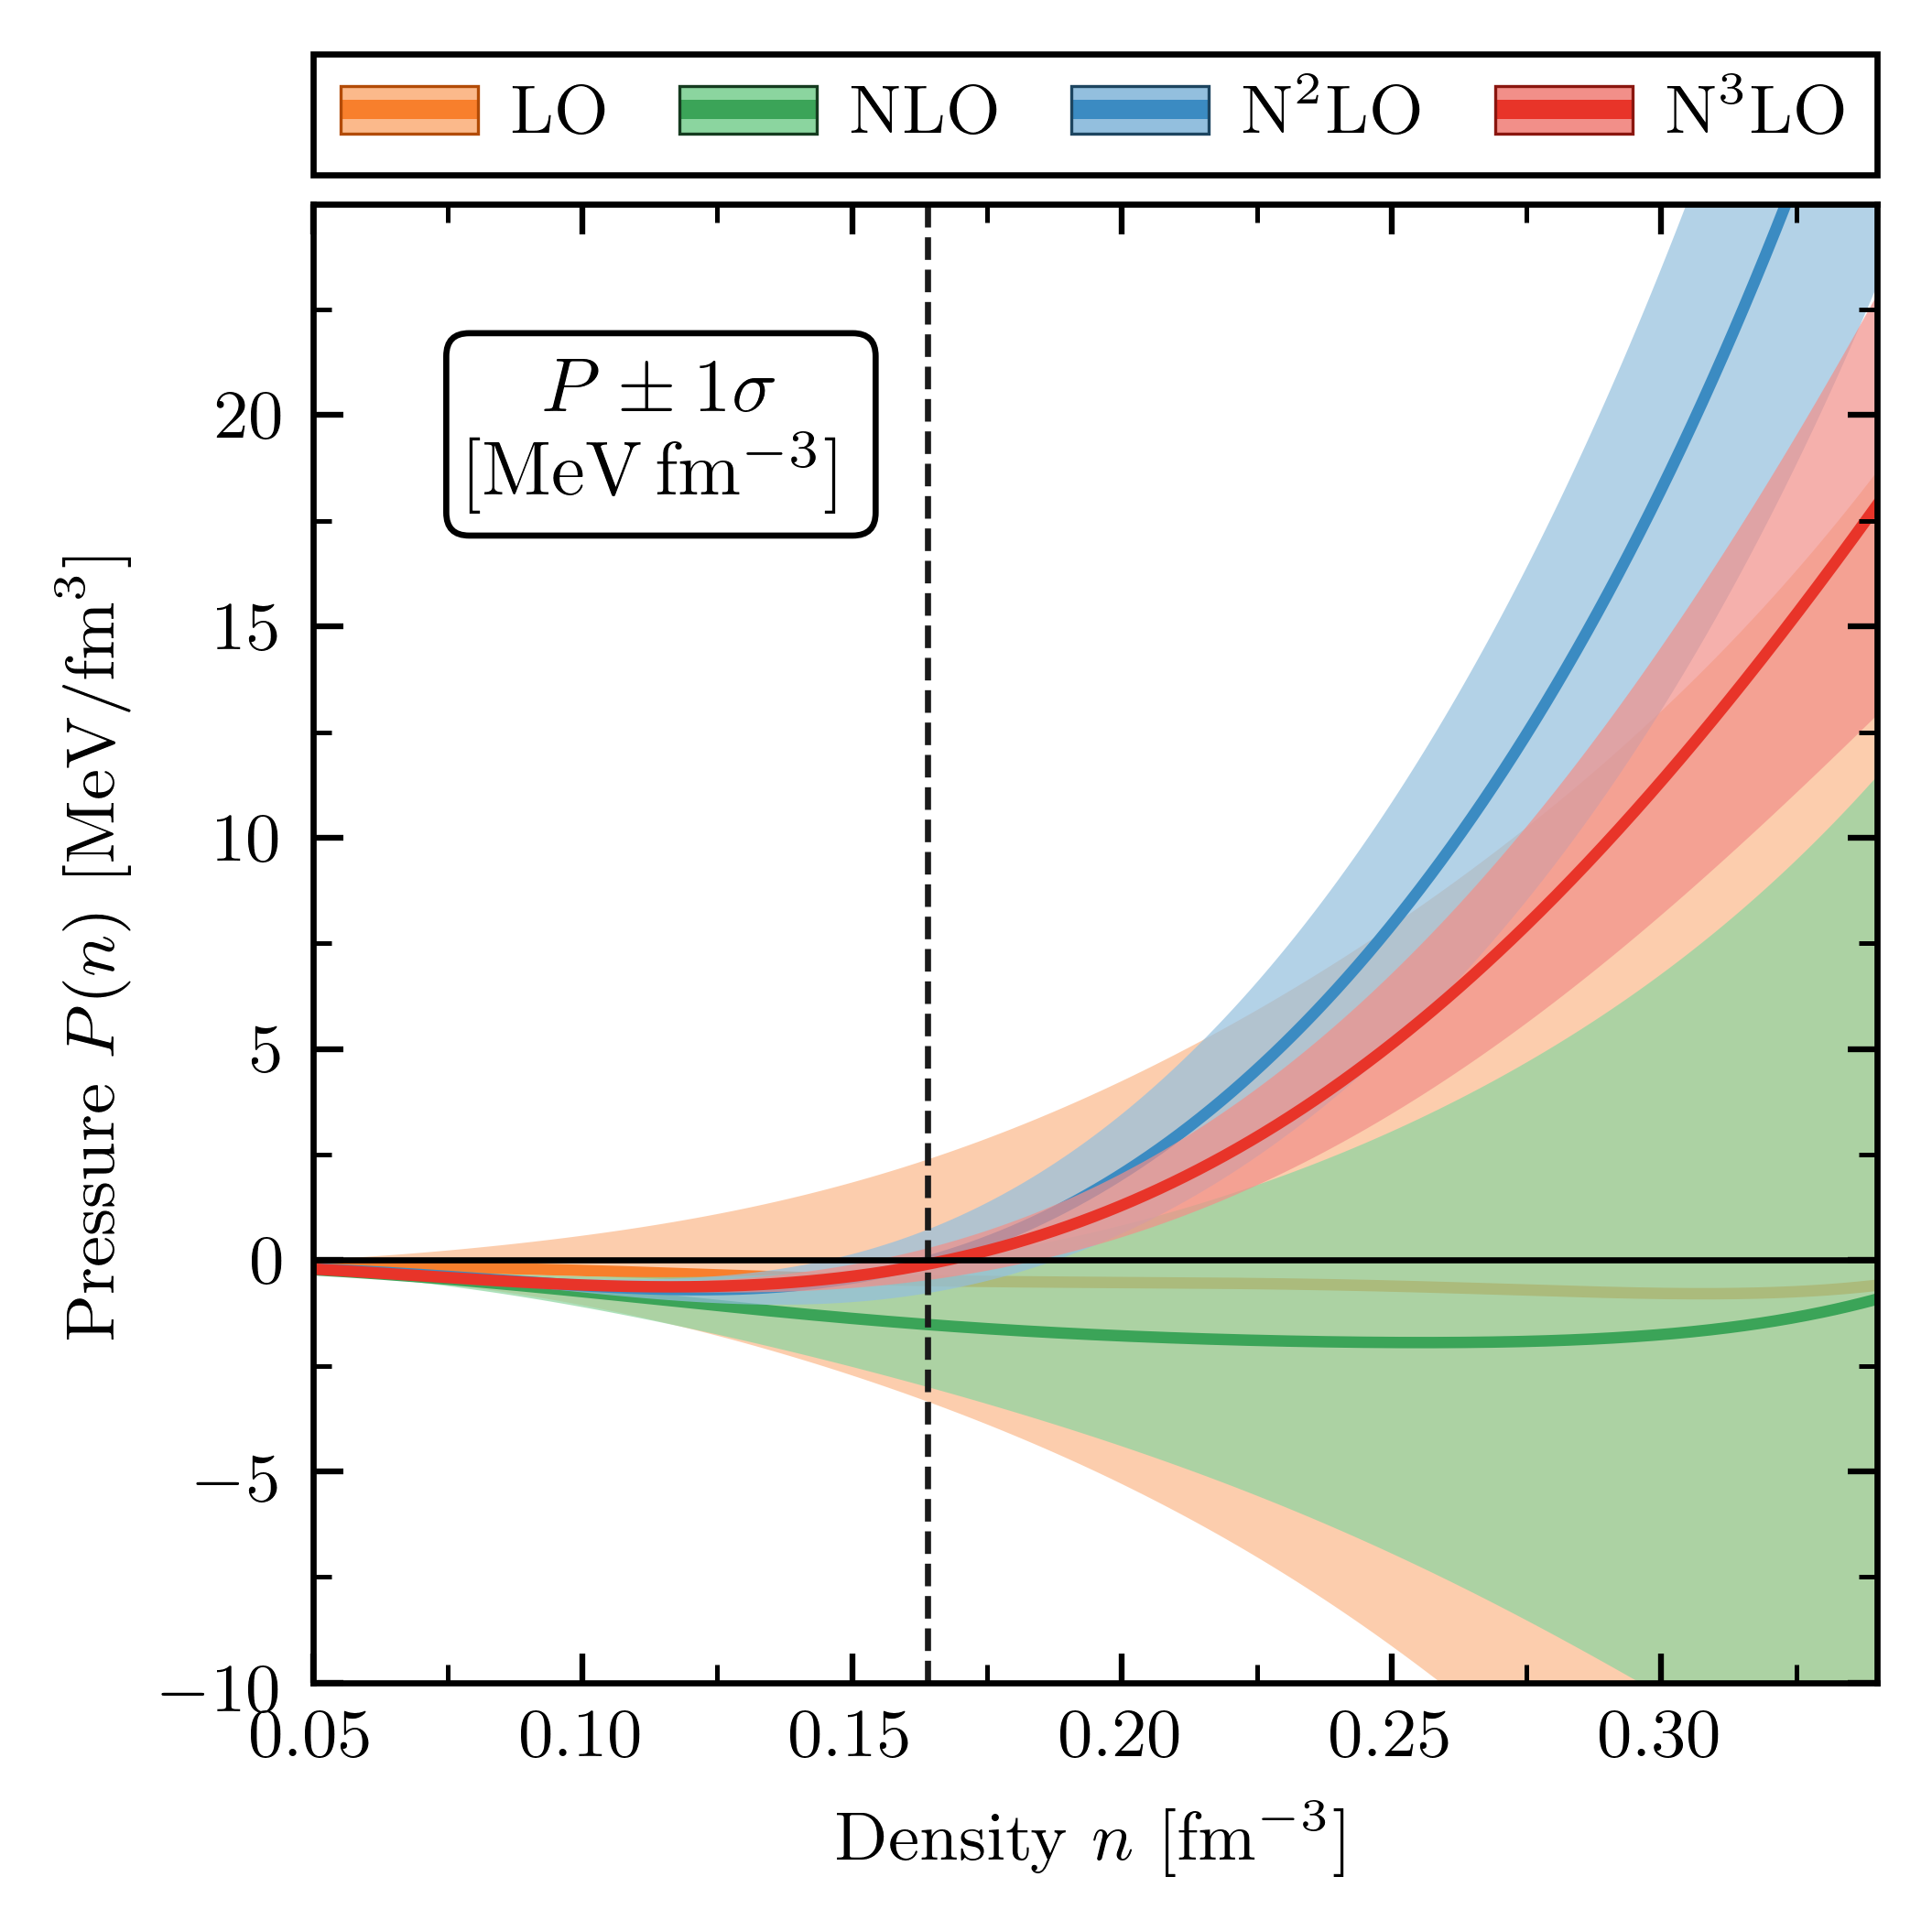

In [25]:
# Fig. 1 of the paper
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]
for i, n in enumerate(chiral.orders):
    plot_obs_vs_density(
        density_all,
        pressures_s[:,i],
        pressure_s_stds[:,i],
        ax=ax,
        color_68=light_colors[i],
   #     color_95=light_colors[i],
        c=colors[i],
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
    )
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, top=True, which='both') # stop for loop after line
ax.axhline(0, 0, 1, c='k', lw=0.8);
ax.set_ylabel(r'$\textrm{Pressure}~P(n)$ [MeV/fm$^{3}$]');
ax.set_ylim(-10, 25-1e-5);
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
ax.text(
    0.1, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
fig.savefig('../plots/pressure_n_2n0.PNG')
plt.show()

In [26]:
# Fig. 6 of this paper, with extended results (uncomment all below to generate)
# fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
# from nuclear_matter import lighten_color
# color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
# cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
# colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
# light_colors = [lighten_color(color, 0.55) for color in colors]
# dark_colors = [lighten_color(color, 1.5) for color in colors]
# for i, n in enumerate(chiral.orders):
#     plot_obs_vs_density(
#         density_all/n0,
#         pressures_s[:,i]/pressure_free[:,i],
#         pressure_s_stds[:,i]/pressure_free[:,i],
#         ax=ax,
#         color_68=light_colors[i],
#    #     color_95=light_colors[i],
#         c=colors[i],
#         add_nsat=i==len(chiral.orders)-1,
#         nsat_n0 = False,
#         zorder=i/10,
#     )
# ax.xaxis.set_major_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.tick_params(right=True, top=True, which='both') # stop for loop after line
# ax.axhline(0, 0, 1, c='k', lw=0.8);
# #ax.axvline(0.34/n0, c='grey', lw=0.8, linestyle='dashdot');
# ax.set_xticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]);
# ax.set_xlim(0.05/n0, 2.0/n0)
# #ax.set_xlim(0.05, 16.4)
# #ax.set_xlim(min(density_all), max(density_all))

# # # add Q value lines
# ax.axvline(x=0.239/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)
# ax.axvline(x=0.65/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)
# ax.axvline(x=1.90/0.164, linestyle='dotted', alpha=1., color='grey', zorder=10)

# #add a secondary x axis with Q on it
# # ax2 = ax.twiny()
# # ax2.set_xlabel('Q')
# # ax2.xaxis.set_major_formatter(plt.FuncFormatter(q_calc))

# #ax.set_xscale('log')
# ax.set_ylabel(r'Scaled pressure $P(n)/P_{FG}(n)$');
# ax.set_xlabel(r'Scaled density $n/n_{0}$')
# #ax.set_ylim(-10, 25-1e-5);  # old one
# ax.set_ylim(0.0, 50.0)
# label = r"""$P(n)/P_{FG}(n) \pm 1\sigma$"""
# ax.text(
#     0.2, 0.85, label, transform=ax.transAxes, ha='left', va='top',
#     multialignment='center', zorder=10, fontsize=10,
#     bbox=dict(facecolor='w', boxstyle='round')
# )
# add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
# #fig.savefig('../plots/pressure_scaled_trunc.PNG')
# plt.show()

In [27]:
# call pressure from chiral.py to save to a file for later use
pressure_s, pressure_s_stds, pressure_s_cov = chiral.pressure(orders='all')
mean_chiral_pressure = pressure_s
std_dev_chiral_pressure = pressure_s_stds
cov_matrix_chiral_pressure = pressure_s_cov

# write this to a file (uncomment to save if desired)
# if density_all.size >= 600:
#     np.savez('pressure_chiral_data', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure, std_dev=std_dev_chiral_pressure, \
#              cov=cov_matrix_chiral_pressure)

#     # open the file here and check it
#     npzfile = np.load('pressure_chiral_data.npz')
#     npzfile.files

#     print(npzfile['mean'].shape, npzfile['std_dev'].shape, npzfile['cov'].shape)

#     std_from_cov = np.sqrt(np.diag(npzfile['cov'][:,:,3]))
#     print(std_from_cov - npzfile['std_dev'][:,3])
# else:
#     print('Not saved.')

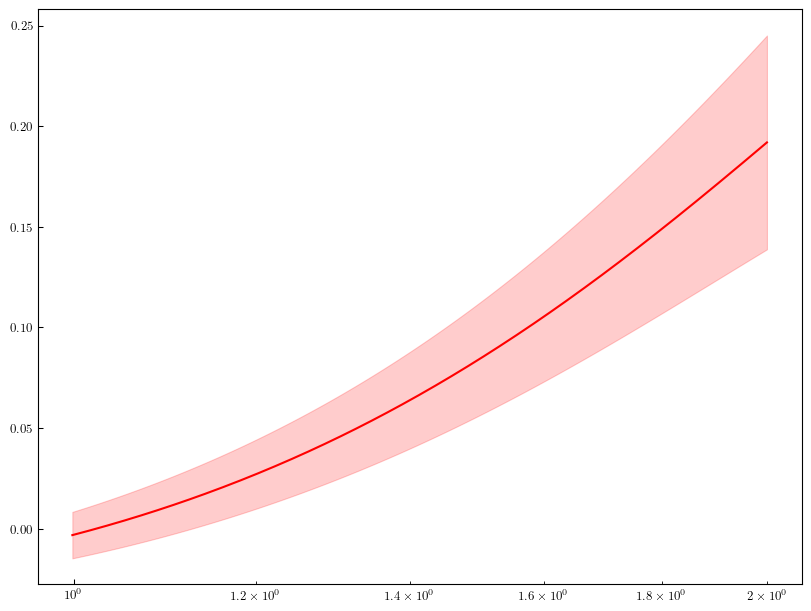

In [28]:
# divide out by the free quark pressure (checking against the plot in chiral EFT in the SNM paper)
dens_scale = density_all/n0
min_dens = np.where(dens_scale>=1.)[0][0]
max_dens = np.where(dens_scale>=2.)[0][0]
dens_scale = dens_scale[min_dens-1:max_dens]

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.plot(dens_scale, pressures_s[min_dens-1:max_dens,3]/pressure_free[min_dens-1:max_dens,3], color='red')
ax.fill_between(dens_scale, \
                (pressures_s[min_dens-1:max_dens,3]-pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                (pressures_s[min_dens-1:max_dens,3]+pressure_s_stds[min_dens-1:max_dens,3])/pressure_free[min_dens-1:max_dens,3], \
                color='red', alpha=0.2)
ax.set_xscale('log')
axes[0, 0].set_ylim(-20, 25)
axes[1, 0].set_ylim(-20, 25)
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

In [29]:
# # saving the scaled results also to an npz file
mean_chiral_pressure_scaled = np.zeros([len(density_all,), 4])
std_dev_chiral_pressure_scaled = np.zeros([len(density_all), 4])
cov_matrix_chiral_pressure_scaled = np.zeros([len(density_all), len(density_all), 4])

for i in range(len(chiral.orders)):
    mean_chiral_pressure_scaled[:,i] = pressure_s[:,i]/pressure_free[:,i]
    std_dev_chiral_pressure_scaled[:,i] = pressure_s_stds[:,i]/pressure_free[:,i]
                            
for i in range(len(chiral.orders)):
    for j in range(len(density_all)):
        for k in range(len(density_all)):
            cov_matrix_chiral_pressure_scaled[j,k,i] = pressure_s_cov[j,k,i]/(pressure_free[j,i]*pressure_free[k,i])
    
#write this to a file (uncomment to do this)
# if density_all.size >= 600:
#     np.savez('../data/eos_data/pressure_chiral_data_scaled_PAL', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
#              cov=cov_matrix_chiral_pressure_scaled)

#     # open the file here and check it
#     npzfile_scaled = np.load('../data/eos_data/pressure_chiral_data_scaled_PAL.npz')
#     npzfile_scaled.files

#     print(npzfile_scaled['mean'].shape, npzfile_scaled['std_dev'].shape, npzfile_scaled['cov'].shape)

#     # checking the correctness
#     print(np.sqrt(np.diag(npzfile_scaled['cov'][:,:,3])) - npzfile_scaled['std_dev'][:,3])
    
if density_all.size >= 600:
    np.savez('../data/eos_data/pressure_chiral_data_scaled_2n0_600pts', density=density_all, dens_scaled=density_all/n0, mean=mean_chiral_pressure_scaled, std_dev=std_dev_chiral_pressure_scaled, \
             cov=cov_matrix_chiral_pressure_scaled)
else:
    print('Not saved.')

---
## Obtaining $\varepsilon(n)$ <a id="calc_eps"></a>

We also want to determine $\varepsilon(n)$, as we will need values of this quantity for calculating the speed of sound in the mixed model of Sec. III in our paper. This is done by calculating

$$
\varepsilon(n) = \frac{1}{n}\left[\frac{E(n)}{A} + M\right] 
$$

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


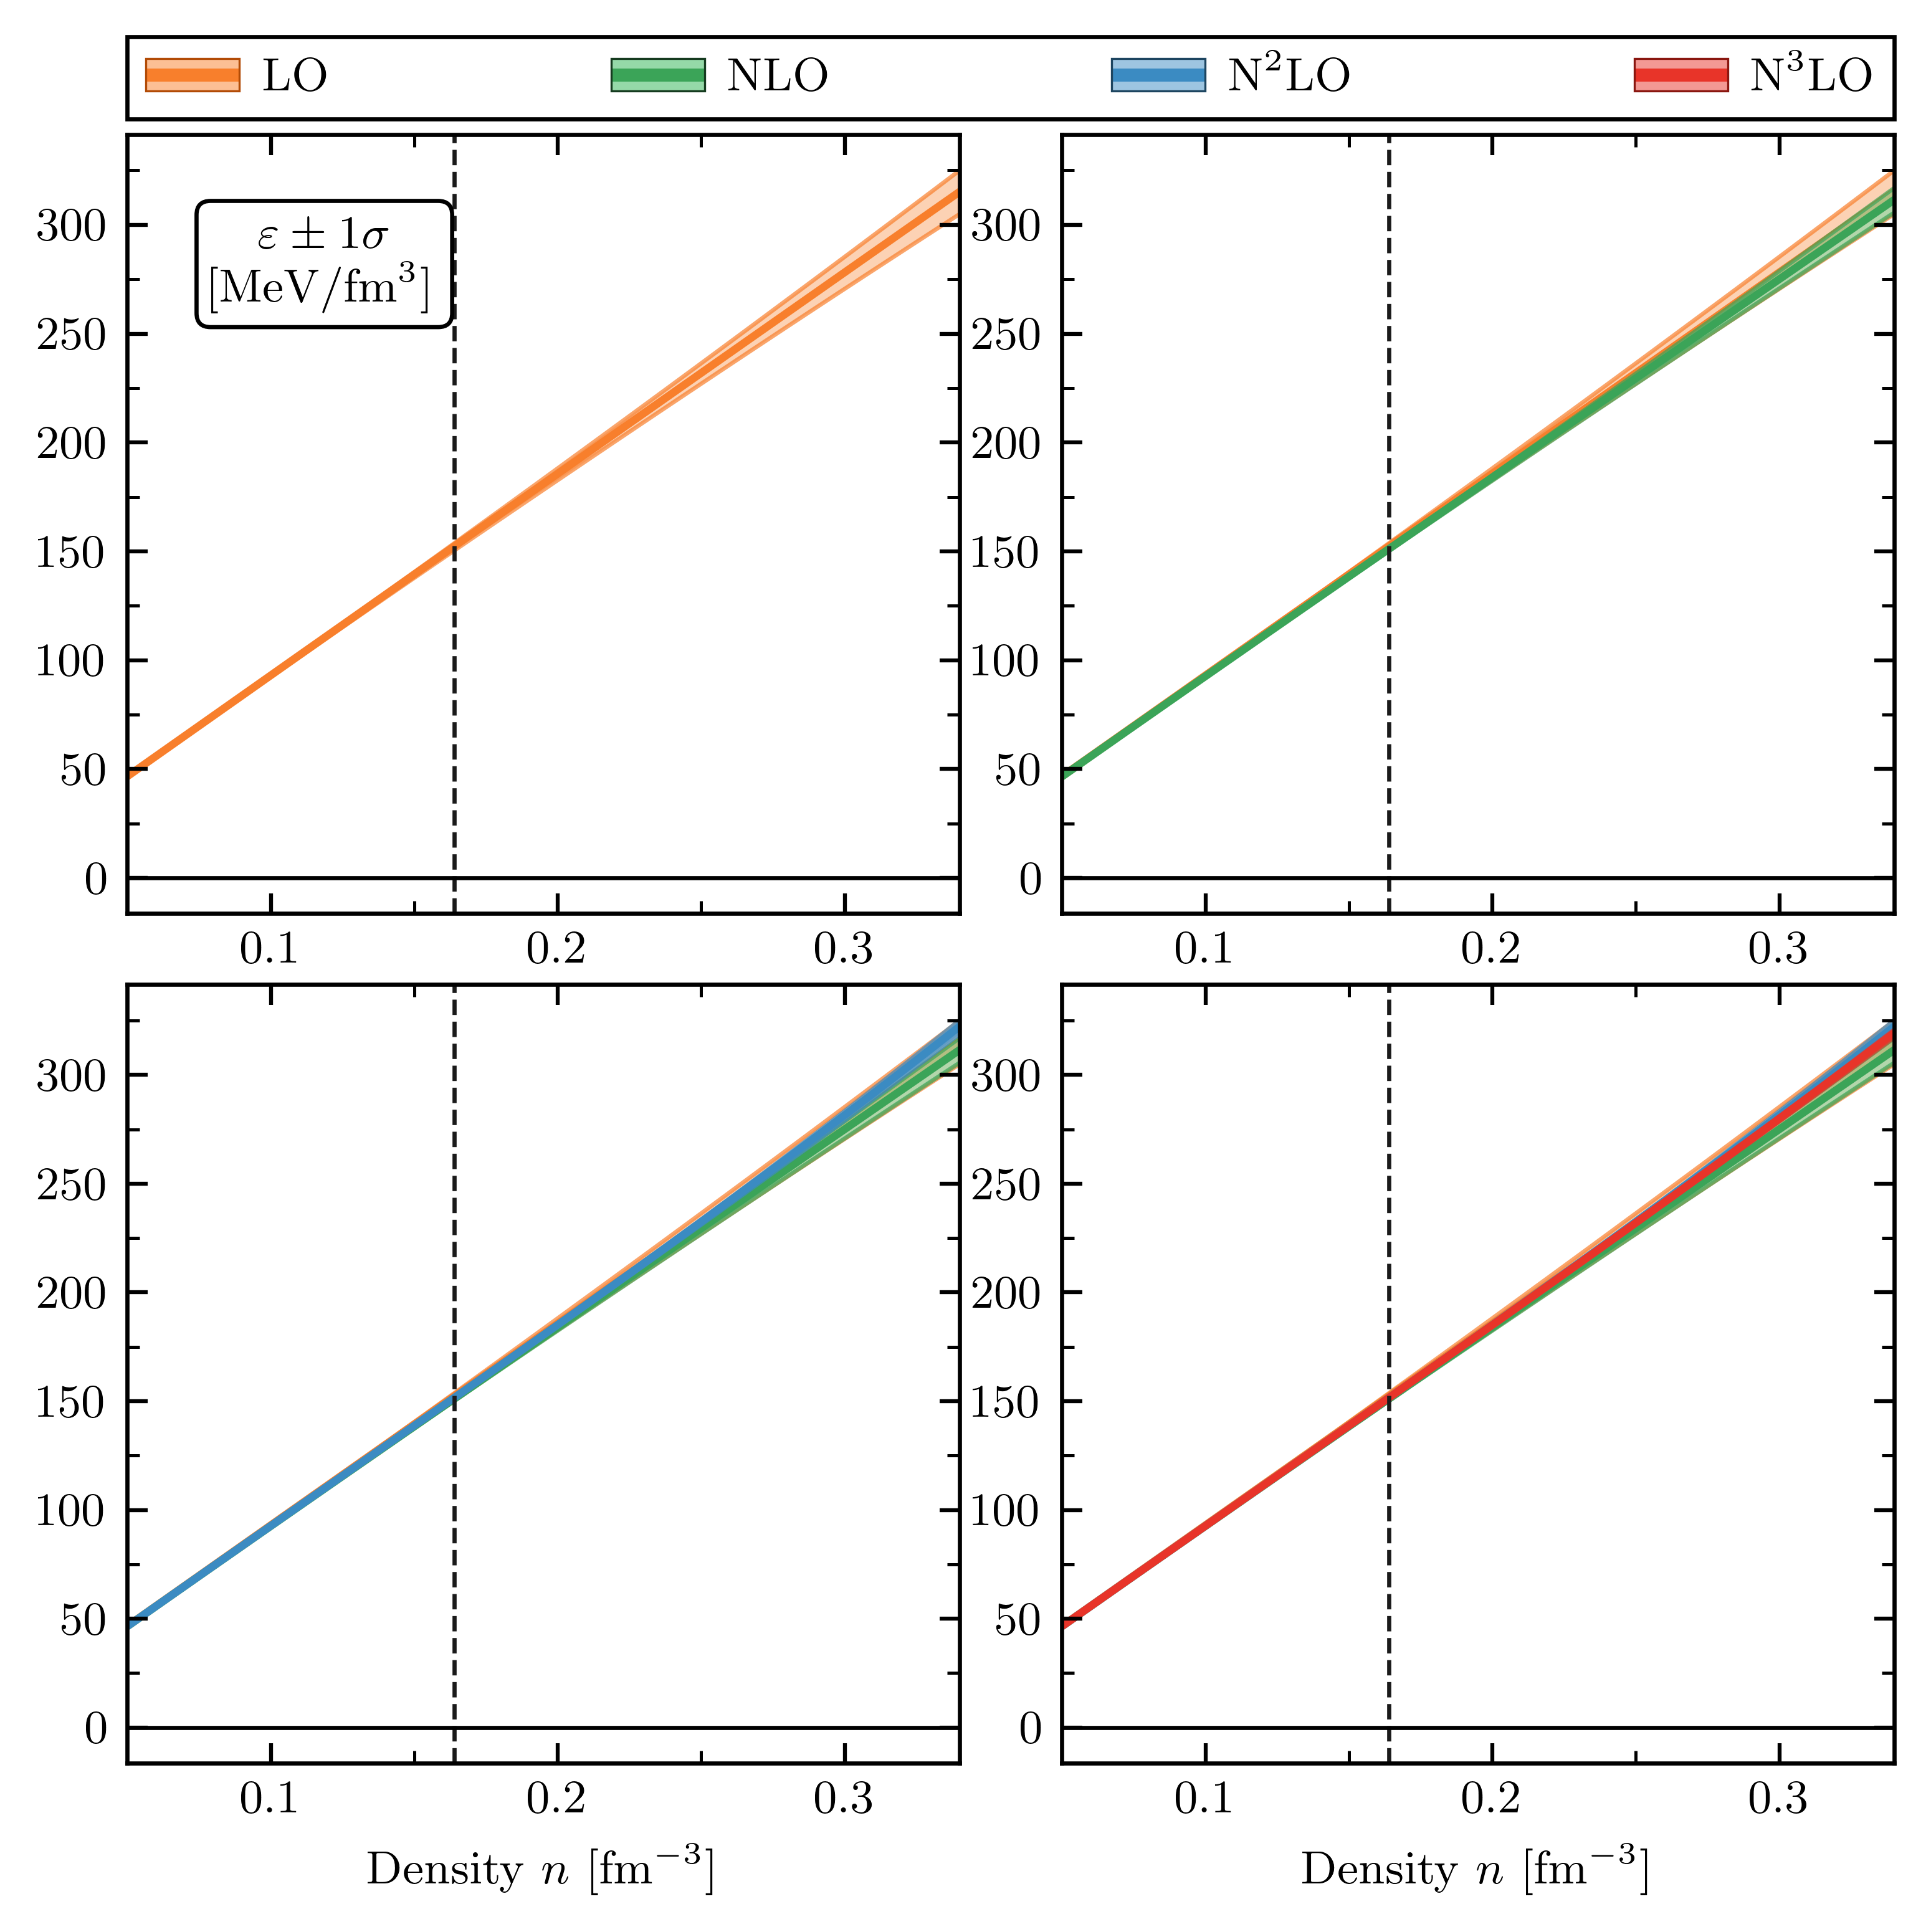

In [30]:
# call the chiral function
energy_density_s, energy_density_s_stds = chiral.energy_dens(add_rest_mass=True)
    
# plot the energy density now wrt n 
fig, axes = plot_obs_panels(
    density_all, y=energy_density_s, dy=energy_density_s_stds, orders=chiral.orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

label = r"""$\varepsilon \pm 1\sigma$
[MeV/fm$^3$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
plt.show()

# save the energy density array to a file (uncomment to save)
#np.savez('../data/eos_data/edens_data_chiral.npz', density=density_all,
# mean=energy_density_s[:,3], std=energy_density_s_stds[:,3])

---

## Calculation of the speed of sound squared, $c_{s}^{2}$ <a id="cs2"></a>

Now we want to calculate the speed of sound. This can be done via the simple relation

$$
c_{s}^{2} = \frac{\partial P(n)}{\partial \varepsilon(n)},
$$

which is what the source code calculates when we look at sampling the speed of sound below. 

To make sure that our speed of sound truncation error is not overestimated, we need to preserve the correlations between the quantities involved and their derivatives. Hence, we use the GP and its derivatives to do this, and sample from the GP so that correlations are preserved. 

__NOTE__: The speed of sound __cannot__ be calculated for densities outside of the range of the original MBPT data. This is due to the extension of the GP kernel not being able to be sampled. However, this is fine as we are mixing in $P(n)$, so we save the speed of sound for comparison to the mixed model only. 

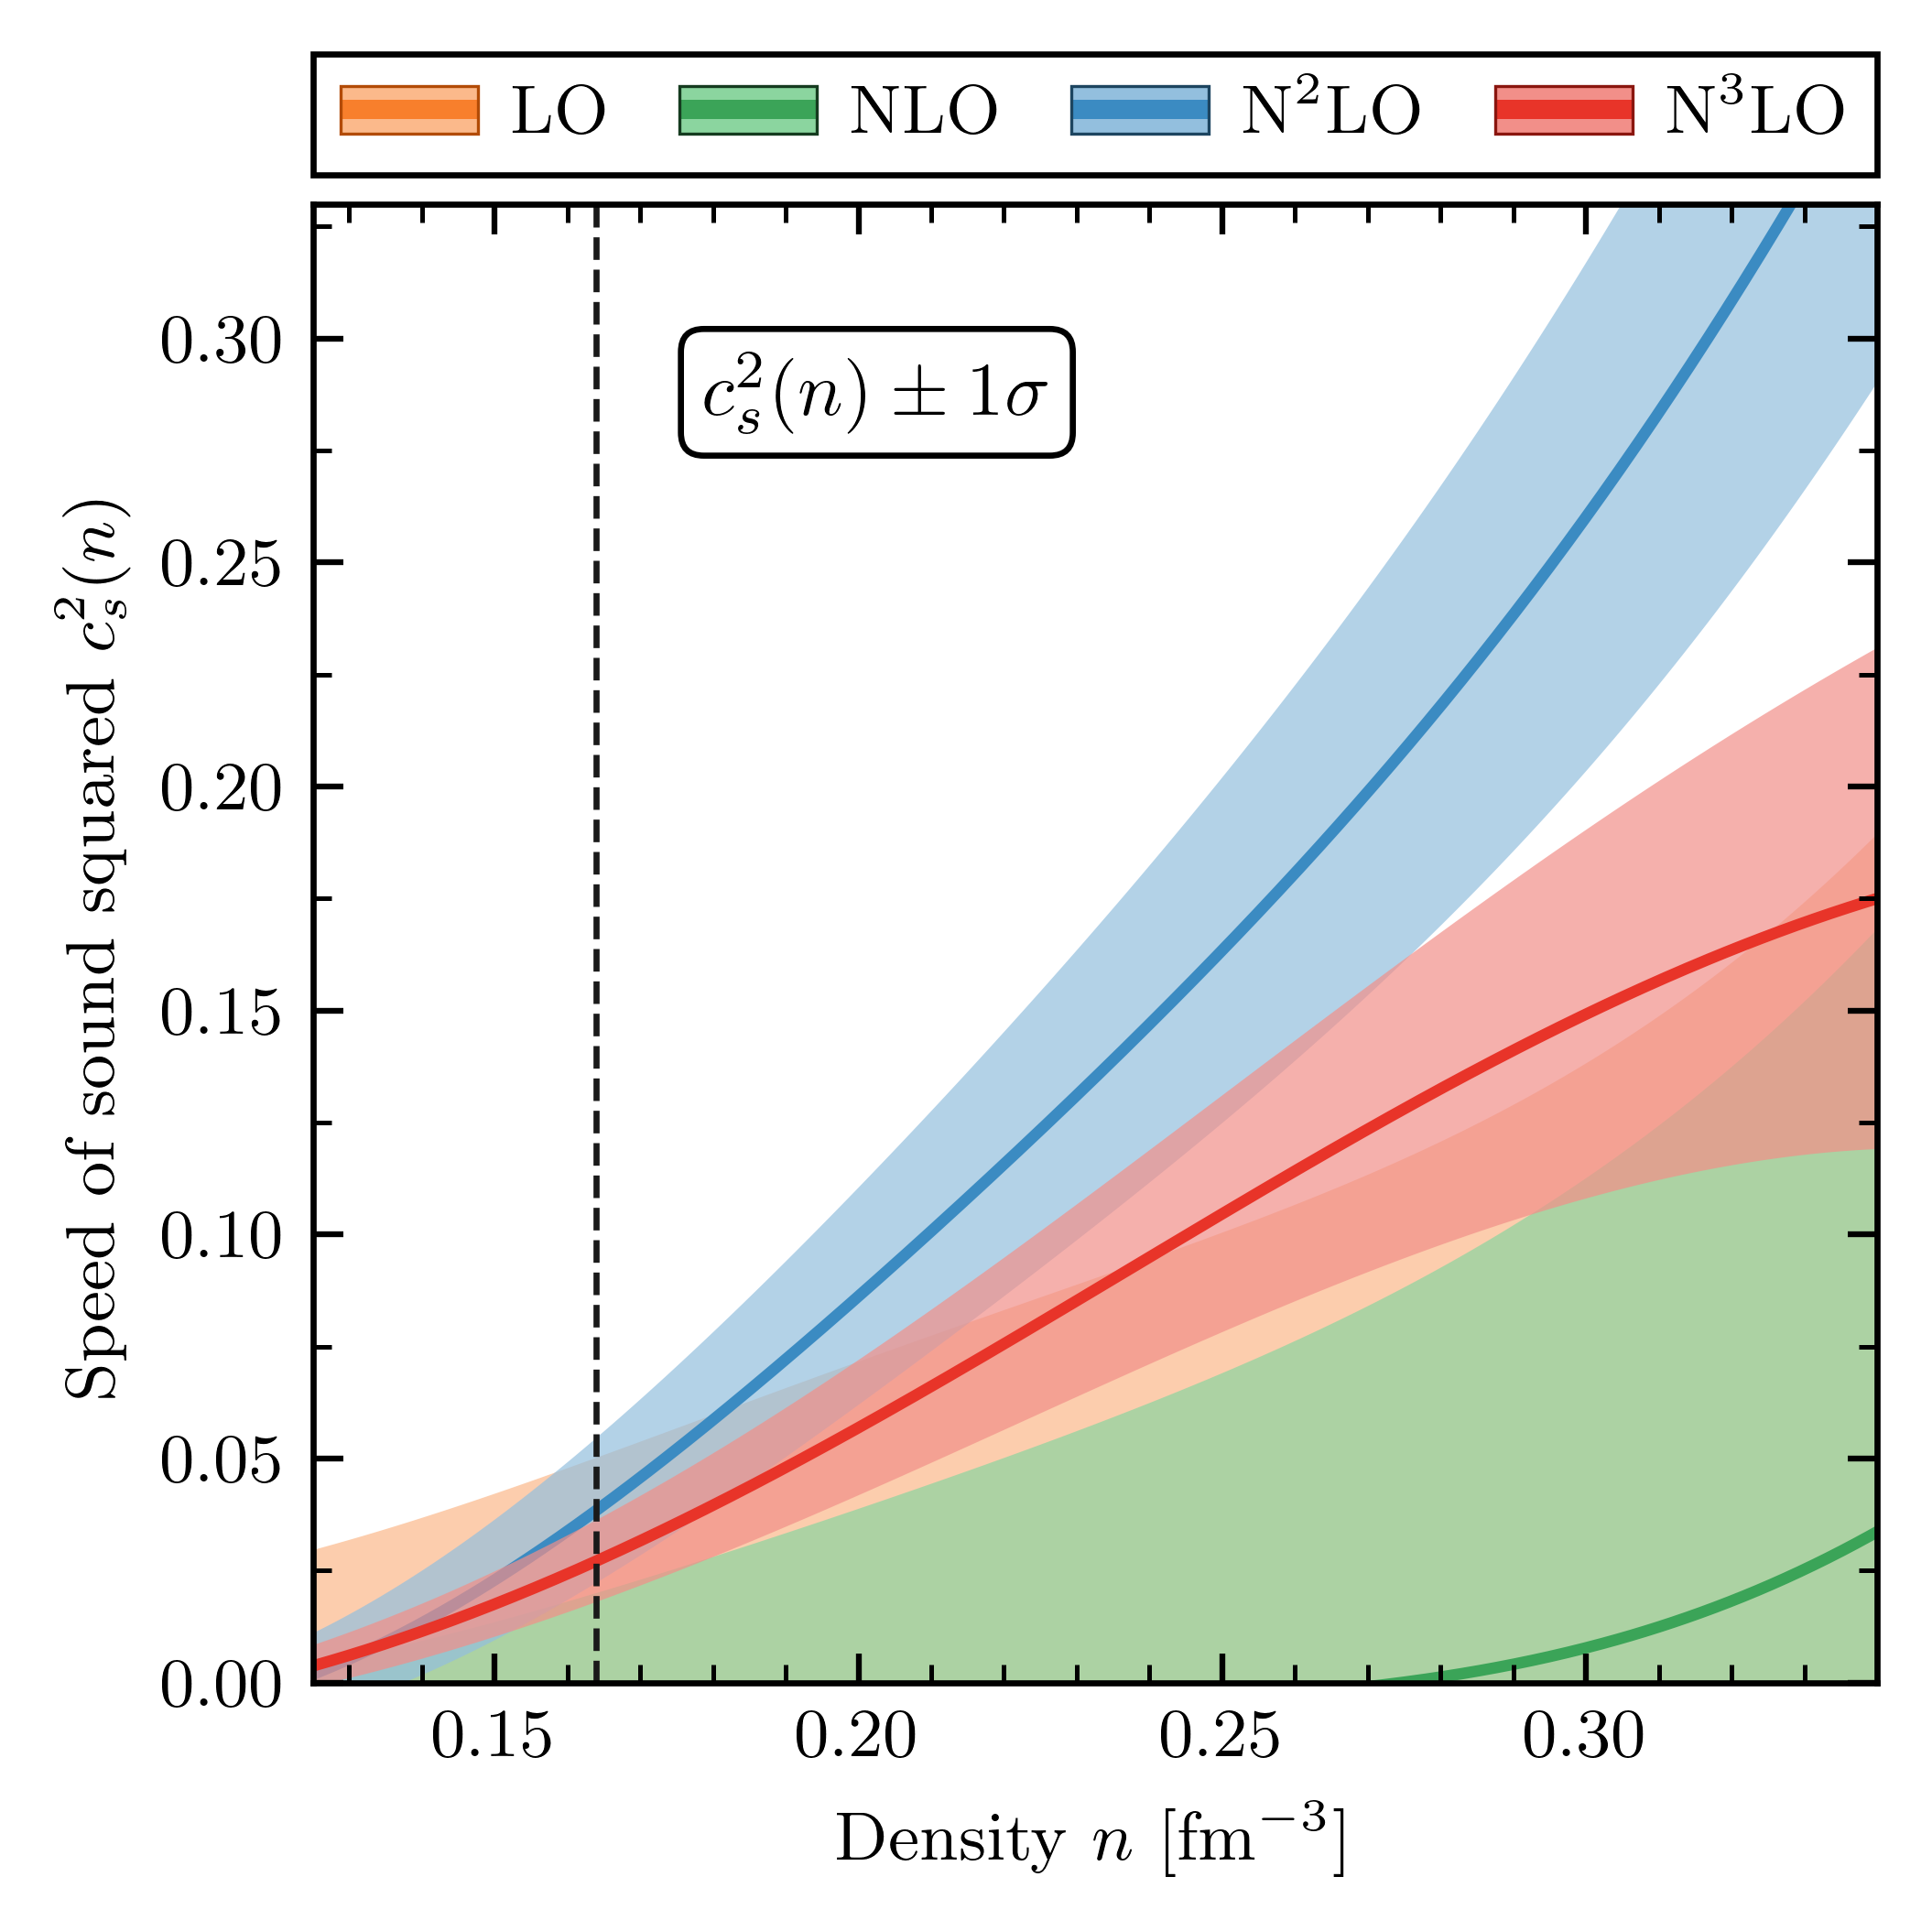

In [32]:
# Fig. 2 of our paper
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4), dpi=600)
from nuclear_matter.matter import mass_neutron, mass_proton
mass_nucleon = (mass_neutron + mass_proton)/2.0
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(chiral.orders)]]
colors = [cmap(0.65 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.55) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(chiral.orders):
    E_per_A_samples_n = obs_nuclear.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        E=E_per_A_samples_n[0].T,
        dE=E_per_A_samples_n[1].T,
        d2E=E_per_A_samples_n[2].T,
        mass=mass_nucleon
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=None,
        add_nsat=i==len(chiral.orders)-1,
        zorder=i/10,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylim(0.0, 0.33)
ax.set_xlim(0.125,0.34)
ax.tick_params(right=True, top=True, which='both')
label = r"""$c_{s}^{2}(n) \pm 1\sigma$"""
ax.text(
    0.25, 0.9, label, transform=ax.transAxes, ha='left', va='top',
    multialignment='center', zorder=10, fontsize=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax.set_ylabel(r'Speed of sound squared $c_{s}^{2}(n)$')
add_top_order_legend(fig, ax, ax, order_labels, colors, light_colors, dark_colors);
#fig.savefig('../plots/cs2_n_2n0.PNG')
plt.show()

# save the data to an npz file to be used later for BMM (uncomment to save)
# if density_all[-1] <= 0.34:
#     np.savez('data/eos_data/speedofsoundchiral.npz', density=chiral.density_all, mean=speed_of_sounds, std=speed_of_sound_stds)
#     npzfile_cs2 = np.load('speedofsoundchiral.npz')
#     npzfile_cs2.files
# else:
#     print('Not saved.')

Now we're done calculating our necessary quantities from $\chi$EFT, and we can move on to using these results in our model mixing!

---

Notebook adapted from derivatives-bands.ipynb in https://github.com/buqeye/nuclear-matter-convergence repository.

Alexandra Semposki, 28 March 2024